Техническое:

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

In [2]:
#for cyrillic characters in matplotlib
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

В качестве корпуса я взяла папки Science, OpenCorpora и Fiction из архива RuCorTestSet. Сначала я составила матрицу term\*document для всей коллекции текстов, потому что с помощью нее можно получить все необходимые частоты. Матрица была составлена с помощью DocFreq, была взята матрица по леммам.
#### Задание 0.
Читаем таблицу и частотный словарь русского языка:

In [3]:
freqtable = pd.read_csv('LM_res.txt',sep='\t')
freqdict = pd.read_csv('freqrnc2011.csv',sep='\t')

freqtable.columns = [x.replace('D:\\Катя\\Учеба\\NLP\\HW1\\TestSet\\','') for x in freqtable.columns]

#### Задание 1.1.
Выделяем глазами-руками ключевые слова в выбранном тексте, смотрим на их абсолютную частоту в корпусе и в самом тексте.

In [4]:
#keywords for selected text
keywords = ['синтез','энергия','термоядерный','реакция','установка',
            'реактор','лазер','мишень','излучение','выделять']
selectedfile = 'Science\\energie.txt'

#extract rows with keywords
keytable = freqtable[freqtable.word.isin(keywords)].loc[:,['word','Total',selectedfile]]
keytable.columns = ['Lemma','Total','Science\\energie.txt']
keytable

,Lemma,Total,Science\energie.txt
9549,установка,52,6
14601,мишень,22,11
16225,лазер,19,7
17117,излучение,19,4
18685,выделять,78,7
27317,термоядерный,18,17
27421,синтез,28,17
31093,энергия,72,19
39111,реактор,9,4
41015,реакция,51,11


Находим количество токенов в корпусе и в выбранном тексте:

In [5]:
alltokens = np.sum(freqtable.loc[:,'Total'])
selectedtokens = np.sum(freqtable.loc[:,selectedfile])
print ('all tokens:',alltokens,'\ntokens in selected text:',selectedtokens)

all tokens: 710741 
tokens in selected text: 1070


Считаем частоту в ipm - по всему корпусу и в выбранном тексте. Кроме того, смотрим на частоту слов в частотном словаре.

In [6]:
#count ipm of keywords - in all collection and in selected text
keytable.loc[:,'Total'] = round((keytable.loc[:,'Total'] * 1000000) / alltokens, 1)
keytable.loc[:,selectedfile] = round((keytable.loc[:,selectedfile] * 1000000) / selectedtokens, 1)
pd.merge(keytable,freqdict[freqdict.Lemma.isin(keywords)].loc[:,['Freq(ipm)','Lemma']],on=['Lemma'])

,Lemma,Total,Science\energie.txt,Freq(ipm)
0,установка,73.2,5607.5,82.6
1,мишень,31.0,10280.4,10.1
2,лазер,26.7,6542.1,4.8
3,излучение,26.7,3738.3,19.4
4,выделять,109.7,6542.1,29.2
5,термоядерный,25.3,15887.9,4.5
6,синтез,39.4,15887.9,22.6
7,энергия,101.3,17757.0,99.7
8,реактор,12.7,3738.3,6.6
9,реакция,71.8,10280.4,97.2


Можно сказать, что все выбранные ключевые слова довольно редки.<br>
Ни одно из этих слов не входит в топ-500 по частоте. <br>
В списке больше всего существительных, но также есть глагол и прилагательное. <br>
Нет слов, встретившихся в большом количестве документов, так как эти слова принадлежат к определенной, довольно узкой, теме.
#### Задание 1.2.
Матрица term\*document по всей коллекции уже составлена.<br>
Функция для поиска документов по запросу Word1&Word2&¬Word3:

In [7]:
def find_texts(df,word1,word2,word3):
    colnames1 = df.loc[df.word == word1][df != 0].dropna(axis=1).columns
    colnames2 = df.loc[df.word == word2][df != 0].dropna(axis=1).columns
    colnames3 = df.loc[df.word == word3][df == 0].dropna(axis=1).columns
    colnames = set(colnames1) & set(colnames2) & set(colnames3)
    return colnames

find_texts(freqtable,'синтез','термоядерный','комиссия')

{'Science\\energie.txt'}

Слова, которые встречаются во всех текстах:

In [8]:
freqtable[freqtable != 0].dropna(axis=0).word

22388    в
22404    и
Name: word, dtype: object

#### Задание 1.3.

Выбираем еще один текст, выбираем шесть ключевых слов, два частотных, два редких.

In [9]:
sselectedfile = 'Science\\16Jul2013_independent_immuno.html.txt'
keywords = ['клетка','раковый','рак','иммунный','лечение','фармакологический','он','быть','клей','наноситься']

Считаем количество токенов в выбранном документе и количество документов в коллекции:

In [10]:
selectedtokens = np.sum(freqtable.loc[:,sselectedfile])
ntotal = len(freqtable.columns) - 2

Задаем колонки будущих таблиц:

In [11]:
table2 = {'word':[],'Fr(L)':[],'Fr(Coll)':[],'Count(w)':[],'tf':[]}
tf_idf = {'word':[],'Count(w)':[],'LengthDoc':selectedtokens,'tf':[],'Count(doc)':[],'N': ntotal,'idf':[],'tf*idf':[]}

Для каждого слова смотрим его частоту в частотном словаре, считаем tf\*idf и заносим все величины в таблицу:

In [12]:
for word in keywords:
    
    absfreq = int(freqtable.loc[freqtable.word == word,sselectedfile])
    tf = absfreq / selectedtokens
    
    ndoc = len(freqtable.loc[freqtable.word == word][freqtable != 0].dropna(axis=1).columns) - 2
    idf = np.log10(ntotal / ndoc)
    
    indict = float(freqdict[freqdict.Lemma == word].loc[:,'Freq(ipm)'])
    incoll = int(freqtable.loc[freqtable.word == word,'Total']) / alltokens
    
    table2['word'].append(word)
    tf_idf['word'].append(word)
    table2['Fr(L)'].append(indict)
    table2['Fr(Coll)'].append(incoll)
    table2['Count(w)'].append(absfreq)
    tf_idf['Count(w)'].append(absfreq)
    table2['tf'].append(tf)
    tf_idf['tf'].append(tf)
    tf_idf['Count(doc)'].append(ndoc)
    tf_idf['idf'].append(idf)
    tf_idf['tf*idf'].append(tf*idf)

Это какая-то таблица, которая была написана в инструкции, не знаю, зачем она нужна:

In [13]:
table2 = pd.DataFrame(table2)[['word','Fr(L)','Fr(Coll)','Count(w)','tf']]
table2

,word,Fr(L),Fr(Coll),Count(w),tf
0,клетка,109.6,0.000132,13,0.025440
1,раковый,3.4,0.000007,3,0.005871
2,рак,22.2,0.000032,6,0.011742
3,иммунный,9.4,0.000010,3,0.005871
4,лечение,46.0,0.000027,3,0.005871
5,фармакологический,0.7,0.000004,3,0.005871
6,он,11791.1,0.011439,3,0.005871
7,быть,12160.7,0.010015,6,0.011742
8,клей,10.4,0.000004,1,0.001957
9,наноситься,4.4,0.000004,1,0.001957


А это таблица с сортировкой по убыванию tf\*idf:

In [14]:
tf_idf = pd.DataFrame(tf_idf)[['word','Count(w)','LengthDoc','tf','Count(doc)','N','idf','tf*idf']]
tf_idf.sort_values(by='tf*idf',ascending=False)

,word,Count(w),LengthDoc,tf,Count(doc),N,idf,tf*idf
0,клетка,13,511,0.025440,22,643,1.465788,0.037290
2,рак,6,511,0.011742,15,643,1.632120,0.019164
5,фармакологический,3,511,0.005871,1,643,2.808211,0.016487
1,раковый,3,511,0.005871,3,643,2.331090,0.013685
3,иммунный,3,511,0.005871,5,643,2.109241,0.012383
4,лечение,3,511,0.005871,13,643,1.694268,0.009947
8,клей,1,511,0.001957,3,643,2.331090,0.004562
9,наноситься,1,511,0.001957,3,643,2.331090,0.004562
6,он,3,511,0.005871,593,643,0.035156,0.000206
7,быть,6,511,0.011742,622,643,0.014421,0.000169


Собственно, первые шесть слов в этой таблице - ключевые слова, следующие два слова - редкие для корпуса, последние два - частые, встречающиеся во многих документах. <br>
Все ключевые слова оказались наверху, в самом низу местоимение и многозначный (и многофункциональный) глагол. <br>
В "стоп-список" стоит включать слова из закрытых классов (союзы, предлоги, местоимения), легкие глаголы; для артиклевых языков - артикли; всевозможные вспомогательные глаголы и глаголы-связки, части регулярных аналитических конструкций.

Теперь посчитаем tf\*idf для всех слов в документе:

In [15]:
wordsinsel = list(freqtable.loc[:,['word',sselectedfile]][freqtable != 0].dropna(axis=0).word)
tf_idf_all = {'word':[],'tf_idf':[]}
for word in wordsinsel:
    absfreq = int(freqtable.loc[freqtable.word == word,sselectedfile])
    tf = absfreq / selectedtokens
    
    ndoc = len(freqtable.loc[freqtable.word == word][freqtable != 0].dropna(axis=1).columns) - 2
    idf = np.log10(ntotal / ndoc)
    
    tf_idf_all['word'].append(word)
    tf_idf_all['tf_idf'].append(tf*idf)

Посмотрим на начало и конец отсортированной по убыванию tf\*idf получившейся таблицы. <br><br>
Начало:

In [17]:
tf_idf_all_sorted = pd.DataFrame(tf_idf_all).sort_values(by='tf_idf',ascending=False)
tf_idf_all_sorted.head(20)

,tf_idf,word
64,0.037290,клетка
109,0.027478,иммунотерапия
161,0.019164,рак
155,0.016487,фармакологический
152,0.016487,immunocore
89,0.016487,якобсен
90,0.014719,ракова
26,0.013685,раков
39,0.013685,раковый
9,0.013534,рака


Конец:

In [18]:
tf_idf_all_sorted.tail(20)

,tf_idf,word
25,0.000305,год
160,0.000268,так
11,0.000236,она
257,0.000230,это
138,0.000217,с
258,0.000215,один
86,0.000211,оно
97,0.000206,он
236,0.000202,его
279,0.000192,от


В топ таблицы вошли все ключевые слова. <br>
В топ также вошли части именованных сущностей и неправильно лемматизированные слова, что не несет никакой тематической информации.<br>
Порогом для ключевых слов может являться tf\*idf > 0.009.
#### Задание 1.4.
Делим весь корпус на 10 примерно равных подкорпусов:


In [19]:
onepart = alltokens / 10

al = 0
i = 1
parts = {}

cols = list(freqtable.columns[2:])
random.seed(7)
random.shuffle(cols)

for column in cols:
    al += np.sum(freqtable[column])
    if i in parts:
        parts[i].append(column)
    else:
        parts[i] = [column]
    if al >= onepart-1000:
        print('part',i,'-',al)
        i += 1
        al = 0
print('part',i,'-',al)

part 1 - 70135
part 2 - 71725
part 3 - 70484
part 4 - 73083
part 5 - 71468
part 6 - 71482
part 7 - 71507
part 8 - 70350
part 9 - 70758
part 10 - 69749


Выбираем два самых частотных слова, а также два слова с самым высоким tf\*idf из предыдущего задания:

In [20]:
mostfreq = freqtable.loc[freqtable.Total == max(freqtable.loc[:,'Total']),:]['word'].to_string(index = False)
secmostfreq = freqtable.loc[freqtable.Total == sorted(freqtable.loc[:,'Total'])[-2],:]['word'].to_string(index = False)

tf_idf_first = tf_idf_all_sorted.head(2).iloc[[0]]['word'].to_string(index = False)
tf_idf_second = tf_idf_all_sorted.head(2).iloc[[1]]['word'].to_string(index = False)

keys = [mostfreq,secmostfreq,tf_idf_first,tf_idf_second]

Считаем относительную частоту слов в каждом подкорпусе, а еще ipm по всему корпусу:

In [21]:
colltable = {x:[] for x in keys}
ipmtable = {'word':[],'Coll(ipm)':[],'Dict(ipm)':[]}
            
for key in keys:
    for i in parts:
        colltable[key].append(float(np.sum(freqtable.loc[freqtable.word == key,parts[i]],axis=1) / 
                                    np.sum(np.sum(freqtable[parts[i]]))))
    ipmtable['Coll(ipm)'].append(round(float(freqtable.loc[freqtable.word == key,'Total'] * 1000000) / alltokens, 1))
    ipmtable['word'].append(key)
    
    #иммунотерапии в словаре нет, к сожалению...
    try: ipmtable['Dict(ipm)'].append(float(freqdict[freqdict.Lemma == key].loc[:,'Freq(ipm)']))
    except: ipmtable['Dict(ipm)'].append('no data')

Таблица относительных частот разных слов по подкорпусам:

In [22]:
colldf = pd.DataFrame(colltable,index=range(1,11))
colldf

,в,и,иммунотерапия,клетка
1,0.035004,0.029771,0.00000,0.000014
2,0.026908,0.030938,0.00007,0.000181
3,0.028872,0.032334,0.00000,0.000057
4,0.028529,0.029118,0.00000,0.000014
5,0.030867,0.030321,0.00000,0.000042
6,0.029644,0.029910,0.00000,0.000112
7,0.028571,0.030780,0.00000,0.000140
8,0.029780,0.030448,0.00000,0.000227
9,0.029113,0.030272,0.00000,0.000509
10,0.027742,0.029678,0.00000,0.000029


Таблица ipm по всему корпусу и по частотному словарю:

In [23]:
ipmdf = pd.DataFrame(ipmtable)[['word','Coll(ipm)','Dict(ipm)']]
ipmdf

,word,Coll(ipm),Dict(ipm)
0,и,30354.2,35801.8
1,в,29494.6,31374.2
2,клетка,132.3,109.6
3,иммунотерапия,7.0,no data


Частоты примерно похожи, только вот редкого слова *иммунотерапия* в частотном словаре не нашлось. <br><br>
Графики относительной частоты по подкорпусам:

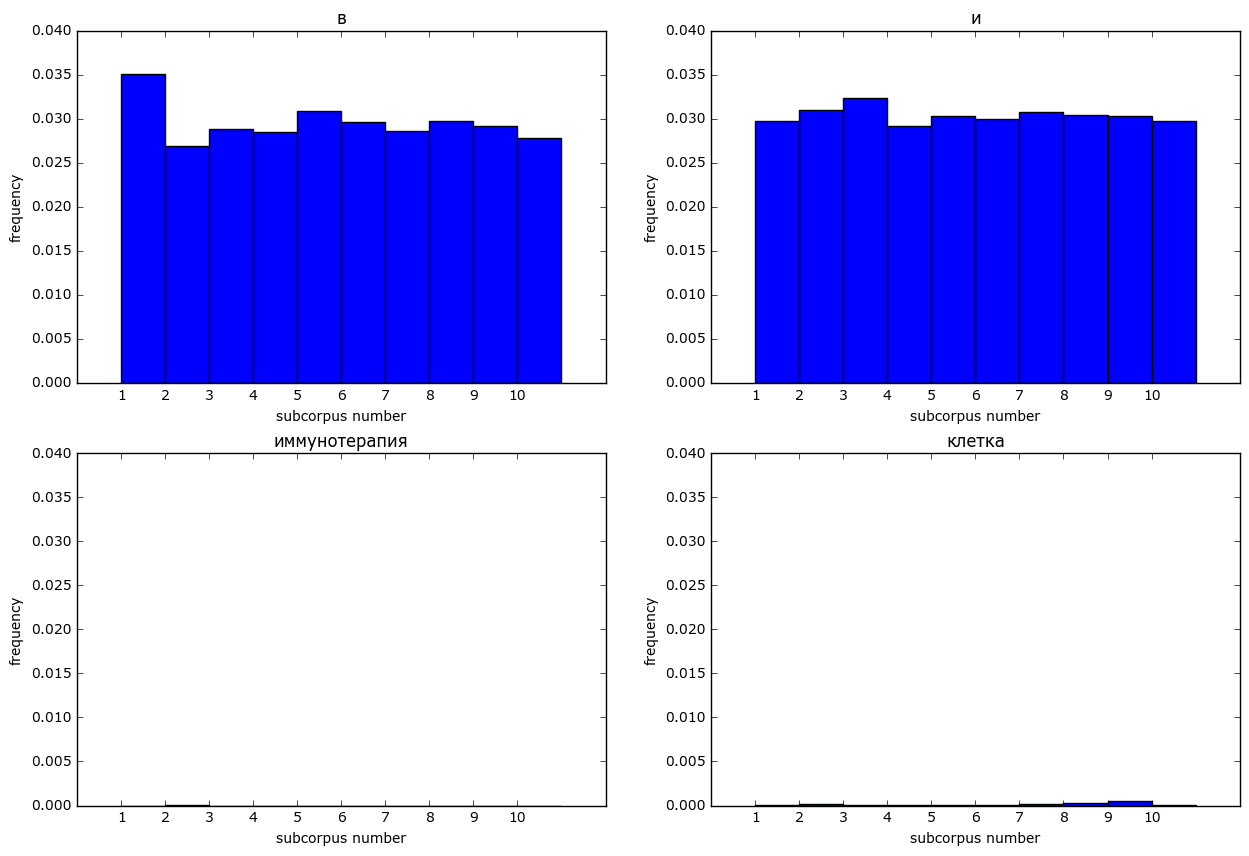

In [24]:
plt.figure(figsize=(15, 10))
for i,col in enumerate(colldf.columns):
    plt.subplot(2,2,i+1)
    plt.bar(range(1,11),colldf[col],width=1)

    axes = plt.gca()
    axes.set_ylim([0,0.04])
    axes.set_xticks(range(1,11))
    plt.xlabel('subcorpus number');
    plt.ylabel('frequency')
    plt.title(col)

Во-первых, частотные слова намного частотнее слов с высоким tf\*idf, что неудивительно. Слова с высоким tf\*idf встречаются скорее окказионально в некоторых подкорпусах (*иммунотерапия* представлена только в одном, *клетка* встречается во всех, но в малом количестве), частотные слова распределены более-менее равномерно.